In [3]:
import feather
import gc
import pandas as pd
import datetime as dt
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm

### データの読み込み

In [4]:
train = feather.read_dataframe('../data/interim/train.ftr')
test = feather.read_dataframe('../data/interim/test.ftr')
train.shape, test.shape

((903653, 55), (804684, 53))

In [5]:
train_tmp = train.copy()
train_tmp['data_type'] = 'train'
test_tmp = test.copy()
test_tmp['data_type'] = 'test'

total = pd.concat([train_tmp, test_tmp], axis=0, sort=True).reset_index(drop=True)
del train_tmp, test_tmp; gc.collect()
total.shape

(1708337, 56)

In [6]:
submit_sample = pd.read_csv('../data/input/sample_submission.csv')
submit_sample.shape

(617242, 2)

### 欠損値の確認

- train, testともに、特にtrafficSourceにおいて欠損が多い。
- trainの欠損は97%程度だが、testは93%程度であり、乖離が見られる。
- 欠損パターンの相関を見てみると、以下の組み合わせの相関が強い。
    - totals.newVisits と trafficSource.isTrueDirect
    - trafficSource.referralPath	と trafficSource.keyword	

In [5]:
def find_missing(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return df.loc[~(df['Total']==0)]

miss_train = find_missing(train)
miss_test = find_missing(test)
display(miss_train)
display(miss_test)

,Total,Percent
trafficSource.campaignCode,903652,99.999889
trafficSource.adContent,892707,98.788694
totals.transactionRevenue,892138,98.725728
trafficSource.adwordsClickInfo.page,882193,97.625195
trafficSource.adwordsClickInfo.adNetworkType,882193,97.625195
trafficSource.adwordsClickInfo.slot,882193,97.625195
trafficSource.adwordsClickInfo.isVideoAd,882193,97.625195
trafficSource.adwordsClickInfo.gclId,882092,97.614018
trafficSource.isTrueDirect,629648,69.678073
trafficSource.referralPath,572712,63.377425


,Total,Percent
trafficSource.adContent,750893,93.315264
trafficSource.adwordsClickInfo.slot,750870,93.312406
trafficSource.adwordsClickInfo.page,750870,93.312406
trafficSource.adwordsClickInfo.isVideoAd,750870,93.312406
trafficSource.adwordsClickInfo.adNetworkType,750870,93.312406
trafficSource.adwordsClickInfo.gclId,750822,93.306441
trafficSource.referralPath,569361,70.755850
trafficSource.isTrueDirect,544171,67.625428
trafficSource.keyword,391032,48.594479
totals.bounces,383736,47.687788


In [6]:
miss_total = miss_train.join(miss_test, lsuffix='_train', rsuffix='_test')
display(miss_total)

,Total_train,Percent_train,Total_test,Percent_test
trafficSource.campaignCode,903652,99.999889,NaN,NaN
trafficSource.adContent,892707,98.788694,750893.0,93.315264
totals.transactionRevenue,892138,98.725728,NaN,NaN
trafficSource.adwordsClickInfo.page,882193,97.625195,750870.0,93.312406
trafficSource.adwordsClickInfo.adNetworkType,882193,97.625195,750870.0,93.312406
trafficSource.adwordsClickInfo.slot,882193,97.625195,750870.0,93.312406
trafficSource.adwordsClickInfo.isVideoAd,882193,97.625195,750870.0,93.312406
trafficSource.adwordsClickInfo.gclId,882092,97.614018,750822.0,93.306441
trafficSource.isTrueDirect,629648,69.678073,544171.0,67.625428
trafficSource.referralPath,572712,63.377425,569361.0,70.755850


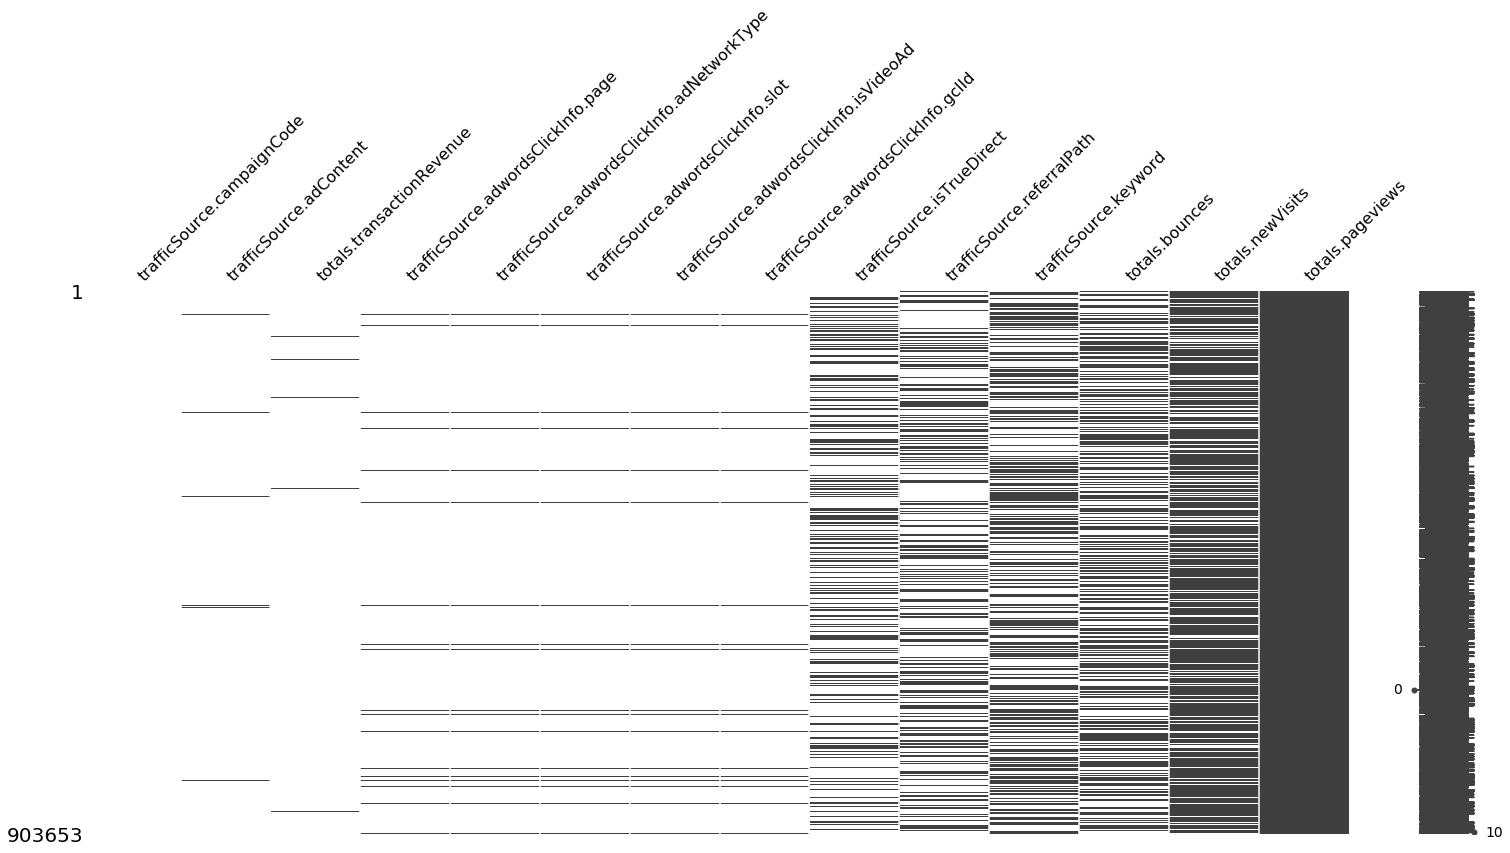

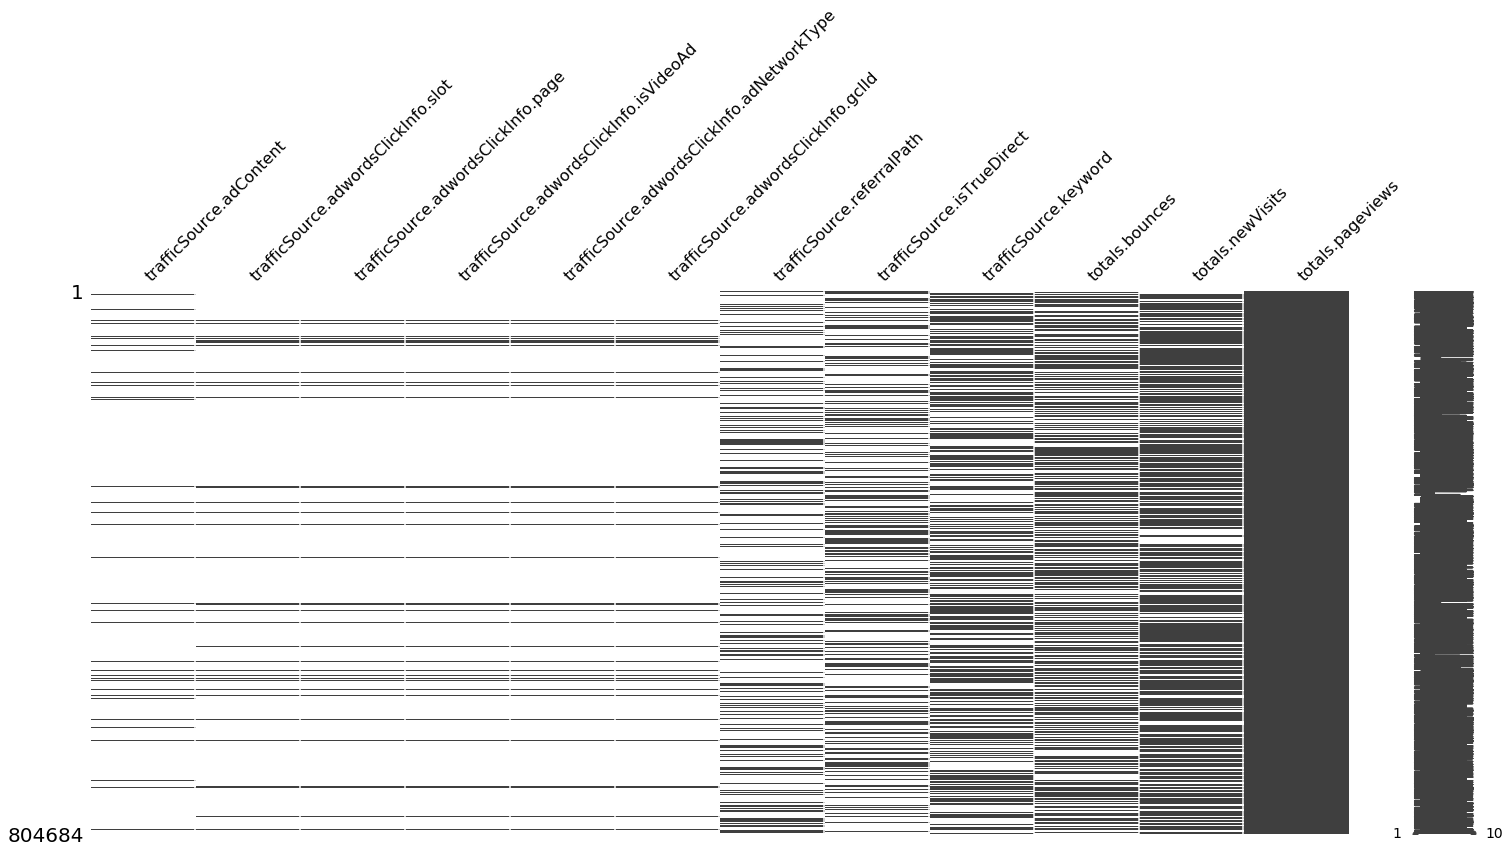

In [7]:
msno.matrix(train[miss_train.index])
msno.matrix(test[miss_test.index])

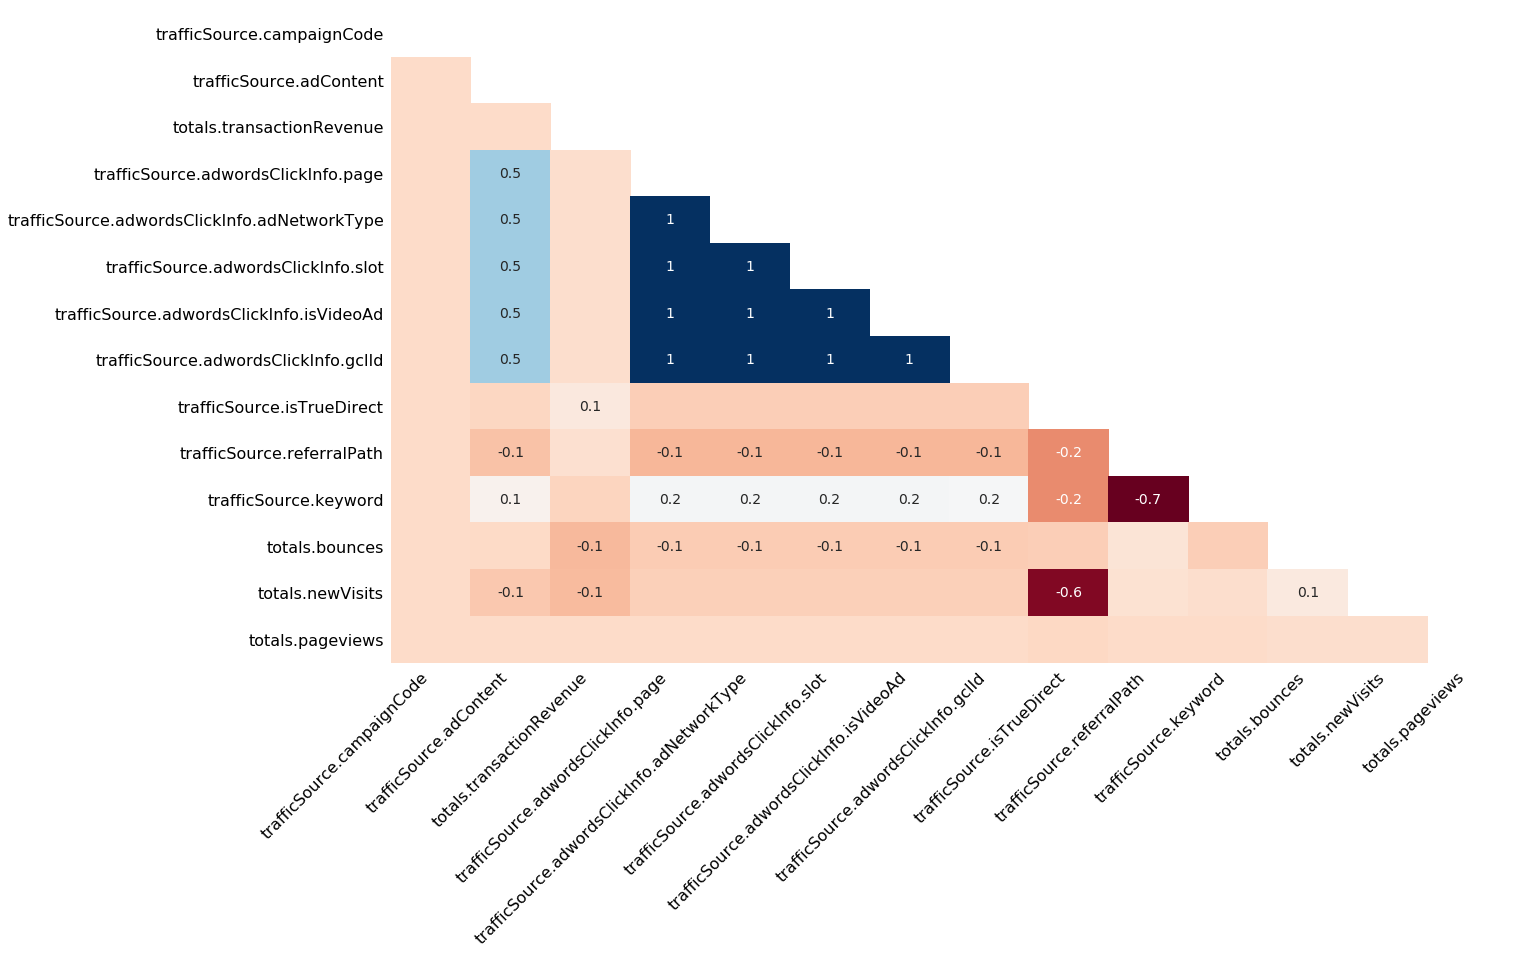

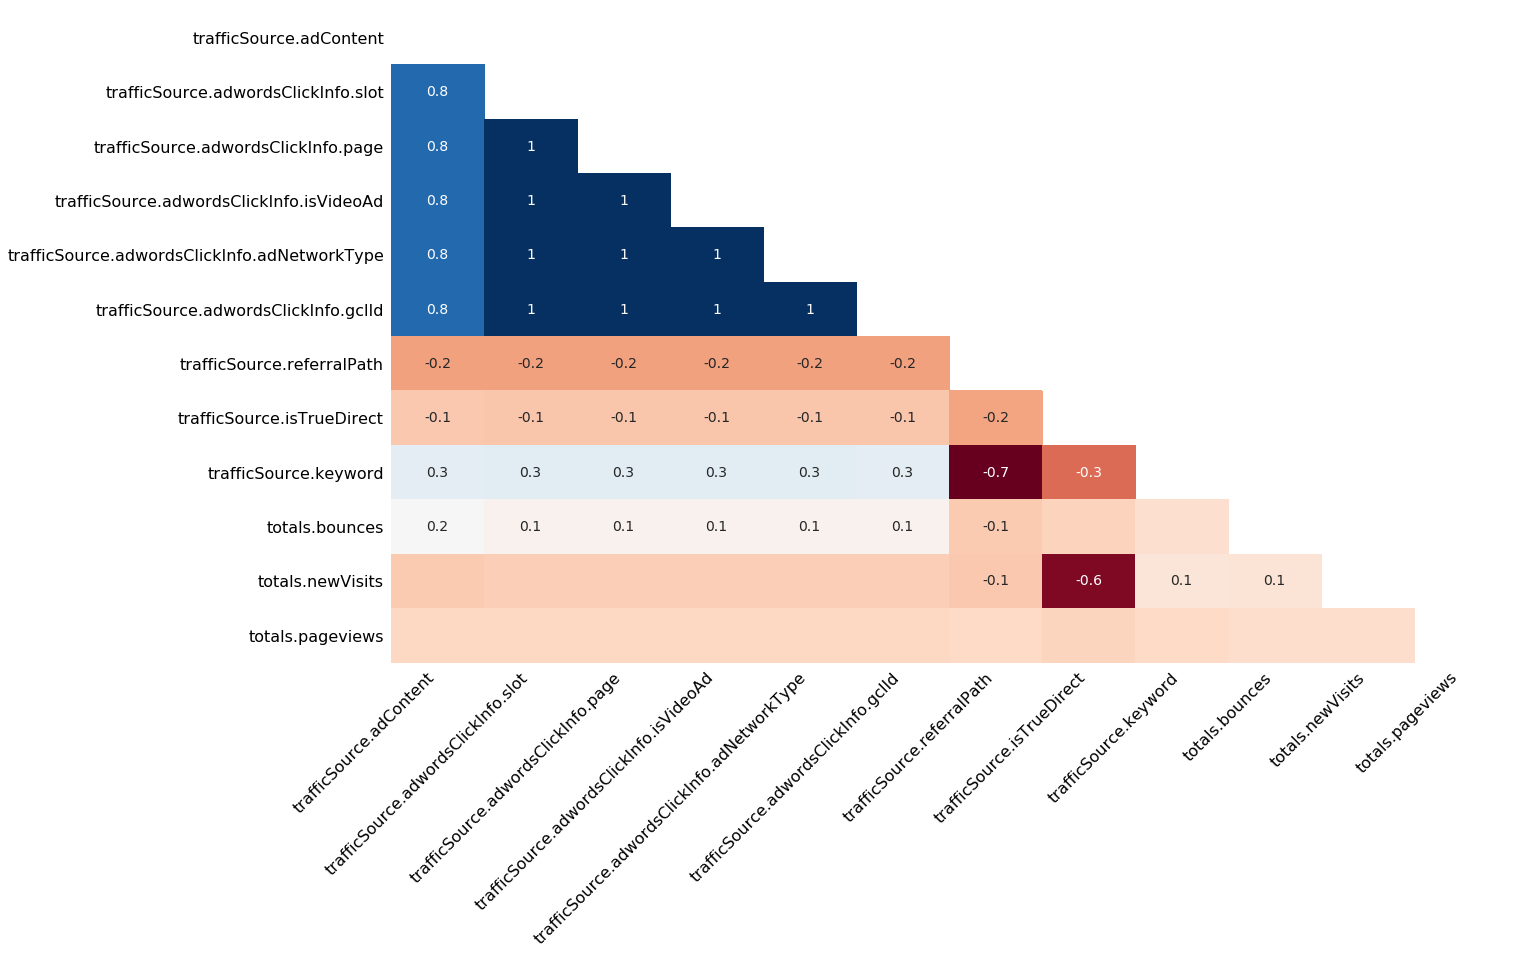

In [8]:
msno.heatmap(train[miss_train.index])
msno.heatmap(test[miss_test.index])

### fullVisitorId
- Google Merchandise Storeの各ユーザーの固有のID

In [82]:
print('Number of unique visitor in train set:', train["fullVisitorId"].nunique(), \
      'out of rows:', len(train), \
      'and ratio is:', train['fullVisitorId'].nunique()/len(train))

print('Number of unique visitor in test set:', test["fullVisitorId"].nunique(), \
      'out of rows:', len(test), \
      'and ratio is:', test['fullVisitorId'].nunique()/len(test))

id_train_test = set(train.fullVisitorId.unique()).intersection(set(test.fullVisitorId.unique()))
print("Number of common visitors in train and test set:", len(id_train_test))

Number of unique visitor in train set: 714167 out of rows: 903653 and ratio is: 0.7903111039303804
Number of unique visitor in test set: 617242 out of rows: 804684 and ratio is: 0.7670613557620134
Number of common visitors in train and test set: 7679


In [13]:
# 2回以上登場しているid
summary_id_train = train.groupby('fullVisitorId').count()['date']
print(len(summary_id_train[summary_id_train>1]), "/" ,len(summary_id_train))
summary_id_train[summary_id_train>1].sort_values(ascending=False).head(10)

93492 / 714167


fullVisitorId
1957458976293878100    278
0824839726118485274    255
3608475193341679870    201
1856749147915772585    199
3269834865385146569    155
0720311197761340948    153
7634897085866546110    148
4038076683036146727    138
0232377434237234751    135
3694234028523165868    129
Name: date, dtype: int64

In [14]:
summary_id_test = test.groupby('fullVisitorId').count()['date']
print(len(summary_id_test[summary_id_test>1]), "/" ,len(summary_id_test))
summary_id_test[summary_id_test>1].sort_values(ascending=False).head(10)

91418 / 617242


fullVisitorId
7282998257608986241    272
3884810646891698298    241
0348420048060754000    177
7477638593794484792    173
460252456180441002     162
7122741899604173060    154
1322101426801959631    153
8839221334461540297    152
0603203541488487946    148
0827807801897731454    127
Name: date, dtype: int64

### channelGrouping
- ユーザーがストアにアクセスする際の経路。

In [31]:
summary_train = train.groupby('channelGrouping').count()['date'].sort_values(ascending=False)
summary_test = test.groupby('channelGrouping').count()['date'].sort_values(ascending=False)
summary_train.name = 'channel_train'
summary_test.name = 'channel_test'
pd.concat([summary_train, summary_test], axis=1, sort=True, join='inner').sort_values('channel_train', ascending=False)

,channel_train,channel_test
channelGrouping,,
Organic Search,381561,357402
Social,226117,128854
Direct,143026,130108
Referral,104838,106469
Paid Search,25326,20301
Affiliates,16403,16512
Display,6262,45021
(Other),120,17


### date
- ユーザーがストアにアクセスした日付。

In [32]:
train_date = pd.to_datetime(train['date'], format='%Y%m%d')
test_date = pd.to_datetime(test['date'], format='%Y%m%d')

In [38]:
max(test_date), min(test_date), max(train_date), min(train_date)

(Timestamp('2018-04-30 00:00:00'),
 Timestamp('2017-08-02 00:00:00'),
 Timestamp('2017-08-01 00:00:00'),
 Timestamp('2016-08-01 00:00:00'))

(array([76170., 77374., 90119., 83821., 94891., 68025., 73607., 81925.,
        81395., 77357.]),
 array([736543. , 736570.1, 736597.2, 736624.3, 736651.4, 736678.5,
        736705.6, 736732.7, 736759.8, 736786.9, 736814. ]),
 <a list of 10 Patch objects>)

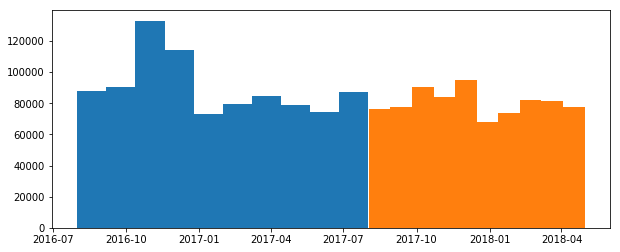

In [39]:
plt.figure(figsize=(10, 4))
plt.hist(train_date)
plt.hist(test_date)

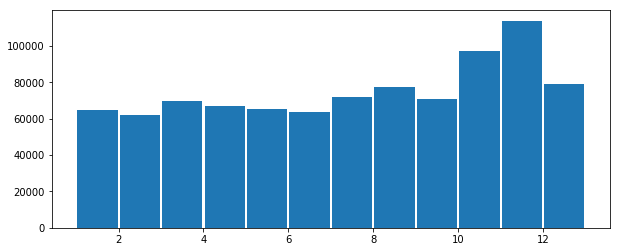

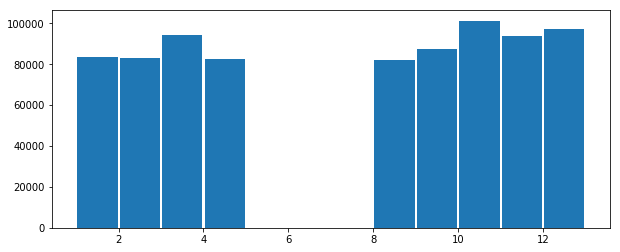

In [62]:
# 月単位で集計する
plt.figure(figsize=(10, 4))
plt.hist(train_date.apply(lambda x: x.month), bins=np.arange(1, 14, 1), rwidth=0.95)
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(test_date.apply(lambda x: x.month), bins=np.arange(1, 14, 1), rwidth=0.95)
plt.show()

### device
- ストアへのアクセスに使用されたデバイスの情報をまとめたもの。
- 元はjson形式で保存されていた。

In [84]:
device_columns = [col for col in train.columns if 'device' in col]
device_columns

['device.browser',
 'device.browserSize',
 'device.browserVersion',
 'device.deviceCategory',
 'device.flashVersion',
 'device.isMobile',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystem',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution']

In [99]:
train[device_columns].dtypes

device.browser                      object
device.browserSize                  object
device.browserVersion               object
device.deviceCategory               object
device.flashVersion                 object
device.isMobile                       bool
device.language                     object
device.mobileDeviceBranding         object
device.mobileDeviceInfo             object
device.mobileDeviceMarketingName    object
device.mobileDeviceModel            object
device.mobileInputSelector          object
device.operatingSystem              object
device.operatingSystemVersion       object
device.screenColors                 object
device.screenResolution             object
dtype: object

In [7]:
def aggregates_train_test(colname):
    summary_train = train.groupby(colname).count()['date'].sort_values(ascending=False)
    summary_test = test.groupby(colname).count()['date'].sort_values(ascending=False)
    summary_train.name = 'train'
    summary_test.name = 'test'
    result = pd.concat([summary_train, summary_test], axis=1, sort=True, join='inner').sort_values('train', ascending=False)
    return result

- not available in demo dataset となるカラムが多い。(16件中12件)
    - browserSize
    - browserVersion
    - flashVersion
    - language
    - mobileDeviceBranding
    - mobileDeviceInfo
    - mobileDeviceMarketingName
    - mobileDeviceModel
    - mobileInputSelector
    - operatingSystemVersion
    - screenColors
    - screenResolution

In [100]:
for col in device_columns:
    print(col)
    display(aggregates_train_test(col))

device.browser


,train,test
device.browser,,
Chrome,620364,552692
Safari,182245,129920
Firefox,37069,26776
Internet Explorer,19375,16099
Edge,10205,10338
Android Webview,7865,26401
Safari (in-app),6850,7357
Opera Mini,6139,8879
Opera,5643,3942


device.browserSize


,train,test
device.browserSize,,
not available in demo dataset,903653,804684


device.browserVersion


,train,test
device.browserVersion,,
not available in demo dataset,903653,804684


device.deviceCategory


,train,test
device.deviceCategory,,
desktop,664479,507100
mobile,208725,262611
tablet,30449,34973


device.flashVersion


,train,test
device.flashVersion,,
not available in demo dataset,903653,804684


device.isMobile


,train,test
device.isMobile,,
False,664530,507140
True,239123,297544


device.language


,train,test
device.language,,
not available in demo dataset,903653,804684


device.mobileDeviceBranding


,train,test
device.mobileDeviceBranding,,
not available in demo dataset,903653,804684


device.mobileDeviceInfo


,train,test
device.mobileDeviceInfo,,
not available in demo dataset,903653,804684


device.mobileDeviceMarketingName


,train,test
device.mobileDeviceMarketingName,,
not available in demo dataset,903653,804684


device.mobileDeviceModel


,train,test
device.mobileDeviceModel,,
not available in demo dataset,903653,804684


device.mobileInputSelector


,train,test
device.mobileInputSelector,,
not available in demo dataset,903653,804684


device.operatingSystem


,train,test
device.operatingSystem,,
Windows,350072,269648
Macintosh,253938,184576
Android,123892,175494
iOS,107665,111669
Linux,35034,28937
Chrome OS,26337,24981
(not set),4695,7120
Windows Phone,1216,459
Samsung,280,631


device.operatingSystemVersion


,train,test
device.operatingSystemVersion,,
not available in demo dataset,903653,804684


device.screenColors


,train,test
device.screenColors,,
not available in demo dataset,903653,804684


device.screenResolution


,train,test
device.screenResolution,,
not available in demo dataset,903653,804684


### geoNetwork
- ユーザーの地域に関する情報をまとめたもの。
- json形式で保存されている。

In [103]:
network_columns = [col for col in train.columns if 'geoNetwork' in col]
network_columns

['geoNetwork.city',
 'geoNetwork.cityId',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.networkLocation',
 'geoNetwork.region',
 'geoNetwork.subContinent']

In [104]:
train[network_columns].dtypes

geoNetwork.city               object
geoNetwork.cityId             object
geoNetwork.continent          object
geoNetwork.country            object
geoNetwork.latitude           object
geoNetwork.longitude          object
geoNetwork.metro              object
geoNetwork.networkDomain      object
geoNetwork.networkLocation    object
geoNetwork.region             object
geoNetwork.subContinent       object
dtype: object

- not available in demo dataset となるカラムが多い。(11件中4件)
    - cityId
    - latitude
    - longitude
    - networkLocation

In [105]:
for col in network_columns:
    print(col)
    display(aggregates_train_test(col))

geoNetwork.city


,train,test
geoNetwork.city,,
not available in demo dataset,508229,424730
Mountain View,40884,33226
(not set),34262,31605
New York,26371,23089
San Francisco,20329,16631
Sunnyvale,13086,14837
London,12607,11015
San Jose,10295,9846
Los Angeles,8670,8368


geoNetwork.cityId


,train,test
geoNetwork.cityId,,
not available in demo dataset,903653,804684


geoNetwork.continent


,train,test
geoNetwork.continent,,
Americas,450377,427026
Asia,223698,173021
Europe,198311,169726
Oceania,15054,13126
Africa,14745,20736
(not set),1468,1049


geoNetwork.country


,train,test
geoNetwork.country,,
United States,364744,352473
India,51140,54177
United Kingdom,37393,35948
Canada,25869,25188
Vietnam,24598,10271
Turkey,20522,8644
Thailand,20123,9736
Germany,19980,18536
Brazil,19783,15649


geoNetwork.latitude


,train,test
geoNetwork.latitude,,
not available in demo dataset,903653,804684


geoNetwork.longitude


,train,test
geoNetwork.longitude,,
not available in demo dataset,903653,804684


geoNetwork.metro


,train,test
geoNetwork.metro,,
not available in demo dataset,508229,424730
(not set),201766,185130
San Francisco-Oakland-San Jose CA,95913,86832
New York NY,26917,23502
London,12571,11072
Los Angeles CA,9995,9958
Seattle-Tacoma WA,7642,7609
Chicago IL,7585,7715
Austin TX,3790,3499


geoNetwork.networkDomain


,train,test
geoNetwork.networkDomain,,
(not set),244881,254168
unknown.unknown,146034,123762
comcast.net,28743,26743
rr.com,14827,13888
verizon.net,13637,12910
ttnet.com.tr,13228,3850
comcastbusiness.net,9985,6841
hinet.net,7919,8014
virginm.net,6414,6180


geoNetwork.networkLocation


,train,test
geoNetwork.networkLocation,,
not available in demo dataset,903653,804684


geoNetwork.region


,train,test
geoNetwork.region,,
not available in demo dataset,508229,424730
California,107495,99174
(not set),27827,21947
New York,26433,23300
England,13198,12626
Texas,8749,11731
Bangkok,7709,4759
Washington,7642,7730
Illinois,7585,7767


geoNetwork.subContinent


,train,test
geoNetwork.subContinent,,
Northern America,390657,377688
Southeast Asia,77800,43834
Southern Asia,59321,61741
Western Europe,59114,56039
Northern Europe,58168,53525
Eastern Asia,46919,44153
Eastern Europe,45249,28758
South America,41731,33381
Western Asia,38443,22523


### sessionId
- ストア訪問に対する固有のID。

In [5]:
train[["fullVisitorId", "sessionId", "visitId"]].head(5)

,fullVisitorId,sessionId,visitId
0,1131660440785968503,1131660440785968503_1472830385,1472830385
1,377306020877927890,377306020877927890_1472880147,1472880147
2,3895546263509774583,3895546263509774583_1472865386,1472865386
3,4763447161404445595,4763447161404445595_1472881213,1472881213
4,27294437909732085,27294437909732085_1472822600,1472822600


In [6]:
# sessionId = fullVisitorId _ visitId
def check_sessionId(data):
    data['make_sessionId'] = f'{data["fullVisitorId"]}_data["visitId"]'
    sum_ = (data['make_sessionId'] == data['sessionId']).sum()
    return sum_

check_sessionId(train), check_sessionId(test)

(0, 0)

In [7]:
print('Number of unique visitor in train set:', train["sessionId"].nunique(), \
      'out of rows:', len(train), \
      'and ratio is:', train['sessionId'].nunique()/len(train))

print('Number of unique visitor in test set:', test["sessionId"].nunique(), \
      'out of rows:', len(test), \
      'and ratio is:', test['sessionId'].nunique()/len(test))

id_train_test = set(train.sessionId.unique()).intersection(set(test.sessionId.unique()))
print("Number of common visitors in train and test set:", len(id_train_test))

Number of unique visitor in train set: 902755 out of rows: 903653 and ratio is: 0.9990062557198394
Number of unique visitor in test set: 803863 out of rows: 804684 and ratio is: 0.9989797237176332
Number of common visitors in train and test set: 5


In [8]:
summary_train = train.groupby('sessionId').count()['date']
summary_train[summary_train>1]

sessionId
0011338928267756760_1471848731    2
0014884852016449602_1483257533    2
0019612470994343873_1496731675    2
0031542961723593073_1495261490    2
0039798900163330977_1485331011    2
0047064119019485310_1480924286    2
0049220146968431383_1472626229    2
0052195661563865896_1496213990    2
0058247020193506669_1494917786    2
0064585292262671874_1493620320    2
0085919192619182437_1497163986    2
0098453420096961116_1498458618    2
0105018660960923258_1475996399    2
0145560792173068997_1490770609    2
0149070251298733325_1493189882    2
0158003745520718168_1478591140    2
0166759258859421359_1501224964    2
0170853116031709671_1496732296    2
0187975600071346667_1501570398    2
0192761237151037034_1472367265    2
0204969659195866276_1477463879    2
022940594084487306_1475650637     2
023880134273808115_1473836398     2
0276186473090634171_1476341892    2
0288998128011317800_1498978602    2
0294366291415691744_1474095585    2
0349443566509786528_1484207959    2
036216376717816224

In [9]:
# 重複しているsessiomnIdのレコード例
train.query('sessionId=="0011338928267756760_1471848731"')

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,make_sessionId
82177,Organic Search,20160822,0011338928267756760,0011338928267756760_1471848731,Not Socially Engaged,1471848731,1,1471849330,Chrome,not available in demo dataset,...,None,None,(not set),None,None,(not provided),organic,None,google,0 1131660440785968503\n1 3773...
212026,Organic Search,20160821,0011338928267756760,0011338928267756760_1471848731,Not Socially Engaged,1471848731,1,1471848731,Chrome,not available in demo dataset,...,None,None,(not set),None,None,(not provided),organic,None,google,0 1131660440785968503\n1 3773...


### socialEngagementType 
- エンゲージメントタイプ。
    - Socially Engaged ...「社会的に関与している」
    - Not Socially Engaged ...「社会的に関与していない」

In [124]:
aggregates_train_test('socialEngagementType')

,train,test
socialEngagementType,,
Not Socially Engaged,903653,804684


### totals
- セッション全体の集計値がまとめられたもの。
- json形式で保存されていた。

In [125]:
totals_columns = [col for col in train.columns if 'totals' in col]
totals_columns

['totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'totals.visits']

In [126]:
train[totals_columns].dtypes

totals.bounces               object
totals.hits                  object
totals.newVisits             object
totals.pageviews             object
totals.transactionRevenue    object
totals.visits                object
dtype: object

In [128]:
for col in totals_columns:
    print(col)
    if col not in test.columns:
        continue
    display(aggregates_train_test(col))

totals.bounces


,train,test
totals.bounces,,
1,450630,420948


totals.hits


,train,test
totals.hits,,
1,446754,417310
2,137952,99547
3,70402,64033
4,42444,38431
5,30939,32748
6,23918,22680
7,19518,18619
8,15484,14233
9,12959,12040


totals.newVisits


,train,test
totals.newVisits,,
1,703060,604370


totals.pageviews


,train,test
totals.pageviews,,
1,452522,423806
2,143770,106024
3,73835,69061
4,45192,41474
5,33411,31301
6,24688,23033
7,19476,18275
8,15272,14314
9,12585,11568


totals.transactionRevenue
totals.visits


,train,test
totals.visits,,
1,903653,804684


### totals.transactionRevenue
- 目的変数

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


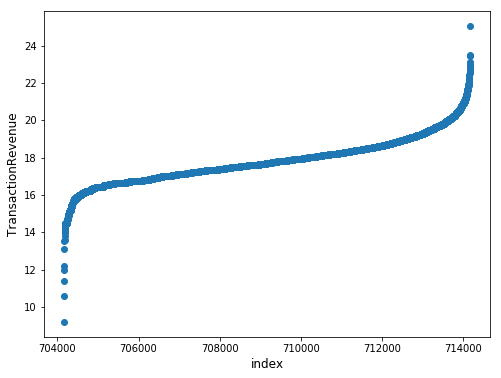

In [139]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].astype('float')
gdf = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

- 収益を生み出す顧客は全登録者数の1.3%程度である。

In [141]:
nzi = pd.notnull(train["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue:", nzi, " and ratio is:", nzi / train.shape[0])
print("Number of unique customers with non-zero revenue:", nzr, "and the ratio is:", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue: 11515  and ratio is: 0.0127427231470487
Number of unique customers with non-zero revenue: 9996 and the ratio is: 0.013996726255903731


### trafficSource
- セッションが発生したトラフィックソースに関する情報がまとめられたもの。
- json形式で保存されていた。

In [143]:
traffic_columns = [col for col in train.columns if 'trafficSource' in col]
traffic_columns

['trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.campaignCode',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

In [144]:
train[traffic_columns].dtypes

trafficSource.adContent                              object
trafficSource.adwordsClickInfo.adNetworkType         object
trafficSource.adwordsClickInfo.criteriaParameters    object
trafficSource.adwordsClickInfo.gclId                 object
trafficSource.adwordsClickInfo.isVideoAd             object
trafficSource.adwordsClickInfo.page                  object
trafficSource.adwordsClickInfo.slot                  object
trafficSource.campaign                               object
trafficSource.campaignCode                           object
trafficSource.isTrueDirect                           object
trafficSource.keyword                                object
trafficSource.medium                                 object
trafficSource.referralPath                           object
trafficSource.source                                 object
dtype: object

In [145]:
for col in traffic_columns:
    print(col)
    if col not in test.columns:
        continue
    display(aggregates_train_test(col))

trafficSource.adContent


,train,test
trafficSource.adContent,,
Google Merchandise Collection,5122,1640
Google Online Store,1245,528
Display Ad created 3/11/14,967,1377
{KeyWord:Google Brand Items},251,167
{KeyWord:Google Merchandise},155,119
{KeyWord:Google Branded Gear},67,28
{KeyWord:Looking for Google Bags?},65,24
Swag with Google Logos,64,83
{KeyWord:Want Google Stickers?},42,22


trafficSource.adwordsClickInfo.adNetworkType


,train,test
trafficSource.adwordsClickInfo.adNetworkType,,
Google Search,21453,11590
Search partners,7,1


trafficSource.adwordsClickInfo.criteriaParameters


,train,test
trafficSource.adwordsClickInfo.criteriaParameters,,
not available in demo dataset,903653,804684


trafficSource.adwordsClickInfo.gclId


,train,test
trafficSource.adwordsClickInfo.gclId,,
CNHp7Nf2ytMCFVlWDQod_IoL5A,20,4
Cj0KCQjwktHLBRDsARIsAFBSb6x3yDhaJwwJNzgCb4oakNpi7L8nkxjmuNVYtZFhYtTYdBKPaWFHpXgaAmXPEALw_wcB,12,3
CjwKEAjwtJzLBRC7z43vr63nr3wSJABjJDgJS6U-a8yZzN8aXHzKhWbsr66K23jUJSI8Jw494AlszRoCVHbw_wcB,10,2
Cj0KEQjw2-bHBRDEh6qk5b6yqKIBEiQAFUz29kvNo825B-xt71wF_gwFnbPlm0-ONGO1keGDD2HcUQQaAkhU8P8HAQ,8,3
Cj0KCQjwwevLBRCGARIsAKnAJvdLU-PddsCe_IiY3kAmzQhsJFNQH5FidTNRj2IK1CET-a0AUdW1ca4aAjsMEALw_wcB,7,3
Cj0KCQjwyN7JBRCZARIsAGixLKpKk1WNPZVQiZ5f-l-kqlWZne5hqGgYDqXOhU1JSFzyLR2LYR6ZEJMaApicEALw_wcB,6,2
CjwKCAjwzMbLBRBzEiwAfFz4gYl-AKAIK_80ighQLCXBygB0IWGLYBvX2BOEz89S61dXw8iqDatAohoCigEQAvD_BwE,6,17
CjwKCAjw1ufKBRBYEiwAPI_r4T7oe2ujh0PRaBNiXIgT3wrVEMk-fHhef4EgMrOCNXUy-tICr8qlGhoCMYYQAvD_BwE,5,6
Cj0KEQjw7dfKBRCdkKrvmfKtyeoBEiQAch0egevYIdXxhHoAm5HZE1KNbC0Bj-QO8dvn1kWY24doU18aAmql8P8HAQ,4,3


trafficSource.adwordsClickInfo.isVideoAd


,train,test
trafficSource.adwordsClickInfo.isVideoAd,,
False,21460,53814


trafficSource.adwordsClickInfo.page


,train,test
trafficSource.adwordsClickInfo.page,,
1,21362,52551
2,73,984
3,10,162
5,7,23
7,3,3
4,2,78
9,2,1


trafficSource.adwordsClickInfo.slot


,train,test
trafficSource.adwordsClickInfo.slot,,
Top,20956,11491
RHS,504,42246


trafficSource.campaign


,train,test
trafficSource.campaign,,
(not set),865347,728927
Data Share Promo,16403,16511
AW - Dynamic Search Ads Whole Site,14244,8933
AW - Accessories,7070,2645
AW - Electronics,96,1
AW - Apparel,46,12


trafficSource.campaignCode
trafficSource.isTrueDirect


,train,test
trafficSource.isTrueDirect,,
True,274005,260513


trafficSource.keyword


,train,test
trafficSource.keyword,,
(not provided),366363,346391
6qEhsCssdK0z36ri,11503,6221
(Remarketing/Content targeting),2298,4940
1hZbAqLCbjwfgOH7,2264,1732
google merchandise store,2209,778
Google Merchandise,1648,480
google store,1277,303
youtube,568,202
(User vertical targeting),489,25761


trafficSource.medium


,train,test
trafficSource.medium,,
organic,381561,357402
referral,330955,235323
(none),143026,130108
cpc,25326,62524
affiliate,16403,16512
cpm,6262,2798
(not set),120,17


trafficSource.referralPath


,train,test
trafficSource.referralPath,,
/,75523,62770
/yt/about/,71036,8127
/analytics/web/,14620,18492
/yt/about/tr/,14599,1
/yt/about/es-419/,12735,1
/yt/about/pt-BR/,12003,2
/yt/about/ru/,11193,1
/yt/about/es/,7092,3
/yt/about/en-GB/,6576,6


trafficSource.source


,train,test
trafficSource.source,,
google,400788,417104
youtube.com,212602,116848
(direct),143028,130124
mall.googleplex.com,66416,54125
Partners,16411,16520
analytics.google.com,16172,21264
dfa,5686,1018
google.com,4669,3672
m.facebook.com,3365,3372


### visitId 
- このセッションの識別子。これは通常_utmbクッキーとして保存されている値の一部です。これはユーザーにのみユニークです。完全にユニークなIDの場合は、fullVisitorIdとvisitIdの組み合わせを使用する必要があります。

In [156]:
train['visitId_datetime'] = train['visitId'].apply(lambda x: dt.datetime.fromtimestamp(x))
test['visitId_datetime'] = test['visitId'].apply(lambda x: dt.datetime.fromtimestamp(x))
train['visitStartTime_datetime'] = train['visitStartTime'].apply(lambda x: dt.datetime.fromtimestamp(x))
test['visitStartTime_datetime'] = test['visitStartTime'].apply(lambda x: dt.datetime.fromtimestamp(x))
train['visitId_datetime'].head(5)

0   2016-09-02 15:33:05
1   2016-09-03 05:22:27
2   2016-09-03 01:16:26
3   2016-09-03 05:40:13
4   2016-09-02 13:23:20
Name: visitId_datetime, dtype: datetime64[ns]

In [164]:
time_delta = train['visitStartTime_datetime'] - train['visitId_datetime']
time_delta.sort_values(ascending=False).head(5)

81163    01:32:26
734272   01:26:07
848733   01:18:42
759936   01:18:19
157556   01:18:15
dtype: timedelta64[ns]

In [169]:
# trainでは、visitStartTime > visitId となる。（visitStartTimeの方が新しい）
delta = train['visitStartTime'] - train['visitId']
print(len(delta[delta<0]))

0


### visitNumber 
- このユーザーのセッション数。これが最初のセッションの場合、これは1に設定されます。

In [8]:
aggregates_train_test('visitNumber')

,train,test
visitNumber,,
1,703060,604370
2,92548,89994
3,35843,35119
4,19157,18729
5,11615,11699
6,7677,8025
7,5413,5781
8,4031,4307
9,3084,3266


- visitNumberは、train,test共通で振られるセッション数となる。（resetされない）

In [14]:
train.query("fullVisitorId == '1957458976293878100'").sort_values('visitStartTime', ascending=True)[['fullVisitorId', 'visitStartTime', 'visitNumber']]

,fullVisitorId,visitStartTime,visitNumber
708283,1957458976293878100,1470328437,38
124293,1957458976293878100,1470419668,39
343370,1957458976293878100,1470744357,40
342297,1957458976293878100,1470758383,41
478864,1957458976293878100,1470858691,42
478176,1957458976293878100,1470863775,43
478367,1957458976293878100,1470866550,44
11357,1957458976293878100,1470931824,45
11005,1957458976293878100,1470934753,46
467844,1957458976293878100,1471007312,47


In [15]:
test.query("fullVisitorId == '1957458976293878100'").sort_values('visitStartTime', ascending=True)[['fullVisitorId', 'visitStartTime', 'visitNumber']]

,fullVisitorId,visitStartTime,visitNumber
614434,1957458976293878100,1501694428,327
613098,1957458976293878100,1501701002,328
497181,1957458976293878100,1501761975,329
496998,1957458976293878100,1501771337,330
497232,1957458976293878100,1501774917,331
427218,1957458976293878100,1501845082,332
425631,1957458976293878100,1501863863,333
425661,1957458976293878100,1501867407,334
425672,1957458976293878100,1501871164,335
671528,1957458976293878100,1502131793,336
